In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os


# Any results you write to the current directory are saved as output.

In [3]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io
from skimage.transform import resize
from imgaug import augmenters as iaa
from tqdm import tqdm
import PIL
from PIL import Image, ImageOps
import cv2
from sklearn.utils import class_weight, shuffle
from keras.losses import binary_crossentropy
from keras.applications.resnet50 import preprocess_input
import keras.backend as K
import tensorflow as tf
from sklearn.metrics import f1_score, fbeta_score
from keras.utils import Sequence
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

WORKERS = 2
CHANNEL = 3

import warnings
warnings.filterwarnings("ignore")
IMG_SIZE = 512
NUM_CLASSES = 5
SEED = 77
TRAIN_NUM = 1000 # use 1000 when you just want to explore new idea, use -1 for full train

# UPDATE on V9:
This kernel have two important updates.

* Before Version 8, I couldn't make Ben's and Cropping method work together nicely, so I emphasized on gray scale. Now, I adjust both functions and beleive that color version is better than gray scale.

* Before Version 9, I found a bug that will cause an old crop function to fail in a private test set (it works fine on training and public test sets). Here, I fix that bug. However, I still cannot guarantee whether there will be any more cases on private test set that will fail the crop function. **Update on V11** Now I was able to have a valid LB score with the new crop function, so if anybody still have some submission errors, that is the reason of other bugs.

## update on V14.
* Compare to circle crop in Section 3.A2 according to @taindow : please visit his kernel : https://www.kaggle.com/taindow/pre-processing-train-and-test-images

Other minor updates. Note on estimation inconsistency and Aravind's history.


# 1. Introduction. Explore first, train later.

Hi everyone! As *Aravind Eye Hospital* is one of my favorite organization in the world; they take care of poor people's eyes for free with an impressive sustainable business model.  I will try my best to contribute something to our community. One intuitive way to improve the performance of our model is to simply improve the quality of input images. In this kernel, I will share two ideas which I hope may be useful to some of you : 

- **Reducing lighting-condition effects** : as we will see, images come with many different lighting conditions, some images are very dark and difficult to visualize. We can try to convert the image to gray scale, and visualize better. Alternatively, there is a better approach. We can try the method of [Ben Graham (last competition's winner)](https://github.com/btgraham/SparseConvNet/tree/kaggle_Diabetic_Retinopathy_competition)
- **Cropping uninformative area** : everyone know this :) Here, I just find the codes from internet and choose the best one for you :)

We are going to apply both techniques to both the official data, and the past competition data (shout out @tanlikesmath for creating this dataset! https://www.kaggle.com/tanlikesmath/diabetic-retinopathy-resized . In the updated version, I also try @donkeys' dataset https://www.kaggle.com/donkeys/retinopathy-train-2015 , which is .png which may be have higer image quality than .jpeg format)

If I found more useful tricks, I will update the notebook, or if you have more useful tricks and would love to share, please let me know!

I use some parts of codes from @mathormad and @artgor kernels. Thanks both of you!

Now let us start by loading the train/test dataframes. The `train_test_split` here is in fact not necessary. But when I first fork the kernel from @mathormad, I found some interesting examples using this split and the current `SEED`, so I continue to use them here.

In [4]:
d = {'id_code': [1, 2, 3, 4,5], 'diagnosis': [0, 1, 2, 3,4]}
df_train = pd.DataFrame(data=d)

In [5]:
# df_train = pd.read_csv('/Users/lucieluneau/Downloads/131128_418031_bundle_archive/trainLabels.csv')
# df_test = pd.read_csv('/Users/lucieluneau/Downloads/131128_418031_bundle_archive/trainLabels.csv')

train_x = df_train['id_code']
train_y = df_train['diagnosis']


df_train.head()

,id_code,diagnosis
0,1,0
1,2,1
2,3,2
3,4,3
4,5,4


From quick investigations of the data (see various pictures below), I found that *Hemorrphages, Hard Exudates and Cotton Wool spots* are quite easily observed. However, I still could not find examples of *Aneurysm* or *Abnormal Growth of Blood Vessels* from our data yet. Perhaps the latter two cases are important if we want to catch up human benchmnark using our model.

## 1.2 Original Inputs

First, let have a glance of original inputs. Each row depicts each severity level. We can see two problems which make the severity difficult to spot on. First, some images are very dark [pic(0,2) and pic(4,4) ] and sometimes different color illumination is confusing [pic (3,3)]. Second, we can get the uninformative dark areas for some pictures [pic(0,1), pic(0,3)]. This is important when we reduce the picture size, as informative areas become too small. So it is intuitive to crop the uninformative areas out in the second case.

In [23]:
%pwd

'/Users/lucieluneau/code/lucieluneau/blindness_detection/notebooks'

In [6]:
%%time
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
fig = plt.figure(figsize=(25, 16))
# display 10 images from each class
for i in range(1,6,1):

    print (f"/Users/lucieluneau/Downloads/bidon/{i}.jpeg")


        

/Users/lucieluneau/Downloads/bidon/1.jpeg
/Users/lucieluneau/Downloads/bidon/2.jpeg
/Users/lucieluneau/Downloads/bidon/3.jpeg
/Users/lucieluneau/Downloads/bidon/4.jpeg
/Users/lucieluneau/Downloads/bidon/5.jpeg
CPU times: user 3.13 ms, sys: 368 µs, total: 3.5 ms
Wall time: 3.45 ms


<Figure size 1800x1152 with 0 Axes>

CPU times: user 123 ms, sys: 12 ms, total: 135 ms
Wall time: 135 ms


<Figure size 1800x1152 with 0 Axes>

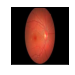

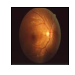

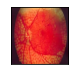

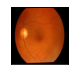

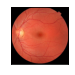

In [68]:
%%time
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
fig = plt.figure(figsize=(25, 16))
# display 10 images from each class

for i in range(1,6,1):
    
    path=(f"/Users/lucieluneau/Downloads/bidon/{i}.jpeg")
    fig = plt.figure()
    ax = fig.add_subplot(1,5,i,xticks=[], yticks=[])
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
        
    plt.imshow(image)


In [9]:
def load_ben_color(path, sigmaX=10):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = crop_image_from_gray(image)
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    image=cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0) , sigmaX) ,-4 ,128)
        
    return image

NameError: name 'crop_image_from_gray' is not defined

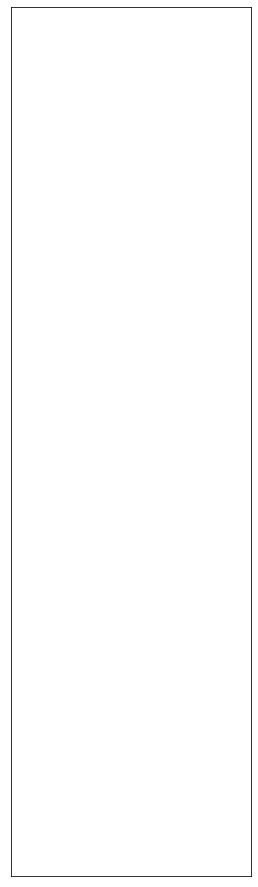

In [10]:
%%time

NUM_SAMP=7
fig = plt.figure(figsize=(25, 16))
for i in range(1,6,1):
 
        path=(f"/Users/lucieluneau/Downloads/bidon/{i}.jpeg")
        ax = fig.add_subplot(1,5,i,xticks=[], yticks=[])
        image = load_ben_color(path,sigmaX=30)

        plt.imshow(image)
       
        
        

We can try gray scale and feel understand better for some pictures, as color distraction is gone. For example, we can see more blood clearer in the upper part of pic(4,4), which has severity of level 4.

CPU times: user 396 ms, sys: 22.8 ms, total: 419 ms
Wall time: 610 ms


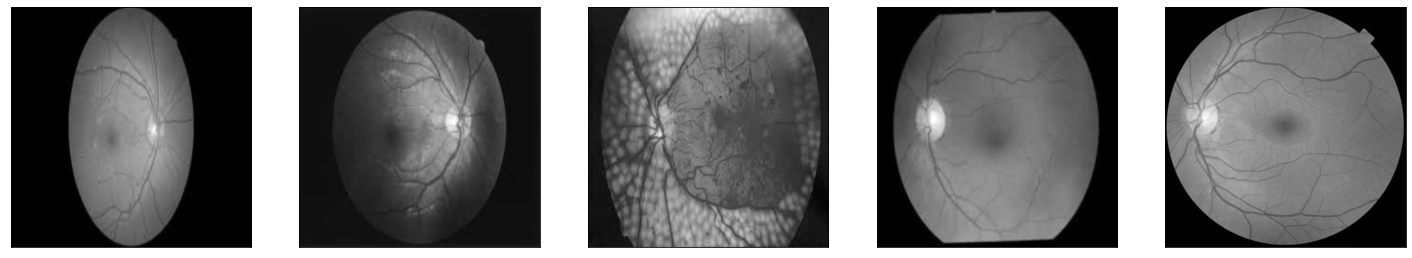

In [64]:
%%time
fig = plt.figure(figsize=(25, 16))

        
for i in range(1,6,1):
        path=(f"/Users/lucieluneau/Downloads/bidon/{i}.jpeg")
        ax = fig.add_subplot(1,5,i,xticks=[], yticks=[])
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#         image=cv2.addWeighted ( image, 0 , cv2.GaussianBlur( image , (0 ,0 ) , 10) ,-4 ,128)
        image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))

        plt.imshow(image, cmap='gray')

For severity level 4, I feel that two examples here are difficult to spot on, pic(4,1) and pic(4,4). As we try zooming to see the details (use real size image), we can see some abnormalities (*cotton wool spots* or *hard exudates* ?) in those eyes clearer (observe the lower-right part of the eye). Therefore, `IMG_SIZE` is definitely important for this problem. In the next section, we shall see better method than gray-scale conversion.

# 2. Try Ben Graham's preprocessing method.

In the last competition, [Ben Graham (last competition's winner)](https://github.com/btgraham/SparseConvNet/tree/kaggle_Diabetic_Retinopathy_competition) share insightful way to improve lighting condition. Here, we apply his idea, and can see many important details in the eyes much better. For full details, please refer to his technical report in the link above.

CPU times: user 5.09 s, sys: 17.6 ms, total: 5.1 s
Wall time: 1.63 s


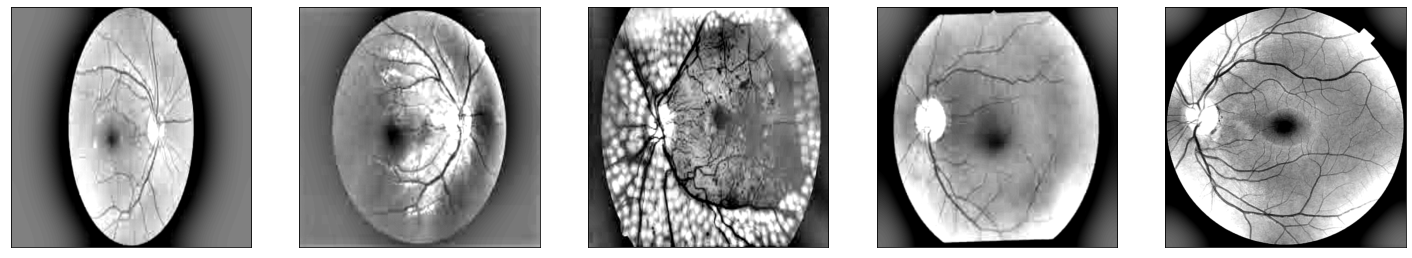

In [70]:
%%time
fig = plt.figure(figsize=(25, 16))

      
        
for i in range(1,6,1):
        path=(f"/Users/lucieluneau/Downloads/bidon/{i}.jpeg")
        ax = fig.add_subplot(1,5,i,xticks=[], yticks=[])
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
        image=cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0) , IMG_SIZE/10) ,-4 ,128) # the trick is to add this line


        plt.imshow(image, cmap='gray')

# 3. Further improve by auto-cropping

To crop out the uninformative black areas which are evident on pic(0,1), pic(0,3) and pic(4,1), we can try auto cropping. I found 4 alternative codes from https://stackoverflow.com/questions/13538748/crop-black-edges-with-opencv and https://codereview.stackexchange.com/questions/132914/crop-black-border-of-image-using-numpy/132934 ... Fortunately one method works perfectly for a gray scale image, but none works on a color image. In this kernel, I modify the method working on gray-scale a bit to make it suitable for a color image.


In [62]:
def crop_image1(img,tol=7):
    # img is image data
    # tol  is tolerance
        
    mask = img>tol
    return img[np.ix_(mask.any(1),mask.any(0))]

def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
    #         print(img1.shape,img2.shape,img3.shape)
            img = np.stack([img1,img2,img3],axis=-1)
    #         print(img.shape)
        return img


In [105]:
# OLD version of image color cropping, use crop_image_from_gray instead
# The above code work only for 1-channel. Here is my simple extension for 3-channels image
def crop_image(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        h,w,_=img.shape
#         print(h,w)
        img1=cv2.resize(crop_image1(img[:,:,0]),(w,h))
        img2=cv2.resize(crop_image1(img[:,:,1]),(w,h))
        img3=cv2.resize(crop_image1(img[:,:,2]),(w,h))
        
#         print(img1.shape,img2.shape,img3.shape)
        img[:,:,0]=img1
        img[:,:,1]=img2
        img[:,:,2]=img3
        return img

'''all of these do not work'''

def crop_image2(image,threshold=5):
    if len(image.shape) == 3:
        flatImage = np.max(image, 2)
    else:
        flatImage = image
    assert len(flatImage.shape) == 2

    rows = np.where(np.max(flatImage, 0) > threshold)[0]
    if rows.size:
        cols = np.where(np.max(flatImage, 1) > threshold)[0]
        image = image[cols[0]: cols[-1] + 1, rows[0]: rows[-1] + 1]
    else:
        image = image[:1, :1]

    return image

def crop_image3(image):
    mask = image > 0

    # Coordinates of non-black pixels.
    coords = np.argwhere(mask)

    # Bounding box of non-black pixels.
    x0, y0 = coords.min(axis=0)
    x1, y1 = coords.max(axis=0) + 1   # slices are exclusive at the top
    
    # Get the contents of the bounding box.
    cropped = image[x0:x1, y0:y1]
    return cropped

def crop_image4(image):
    _,thresh = cv2.threshold(image,1,255,cv2.THRESH_BINARY)
    contours,hierarchy = cv2.findContours(thresh,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    x,y,w,h = cv2.boundingRect(cnt)
    crop = image[y:y+h,x:x+w]
    return crop



### Try Cropping the images

I have tested on around 200 images, and the method works great. However, if anybody find the outlier cases which cause the auto crop to fail, please let me know. I think now the eye pictures are very like the moon by the way :)

**IMPORTANT UPDATE on Kernel V.9** I found that there is indeed a case in private test set making the old version of crop function fail. (I spent my 13 submissions until I found this bug) E.g. if there is an adversarial image (super dark) in the private test set, the crop function will crop everything and result in 0 dimension image. I have fixed this bug in this kernel version, but I still could not guarantee whether there are other cases in a private test that will make the crop function fail or not. **Update on V11** Now I was able to have a valid LB score with the new crop function, so if anybody still have some submission errors, that is the reason of other bugs.


# 3.A Important Update on Color Version of Cropping & Ben's Preprocessing
At first, when I wrote this kernel, I could not make a color crop nicely, so I thought that gray scale is a better representation. Now I believe that color version is better, so from this point on I will use color cropping

Below is the cropped of the color version. For color version, note that I use argument `sigmaX = 30` of `cv2.GaussianBlur`, where Ben actually used `sigmaX = 10` which may have better performance. I just feel that this `sigmaX = 30` or `sigmaX = 50` make beautiful [sometimes bloody] yellow moon pictures. Just for the purpose of illustration.

Please refer to https://www.tutorialkart.com/opencv/python/opencv-python-gaussian-image-smoothing/ . 

In [156]:
def load_ben_color(path, sigmaX=10):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = crop_image_from_gray(image)
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    image=cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0) , sigmaX) ,-4 ,128)
        
    return image

CPU times: user 2.6 s, sys: 15.6 ms, total: 2.61 s
Wall time: 1.04 s


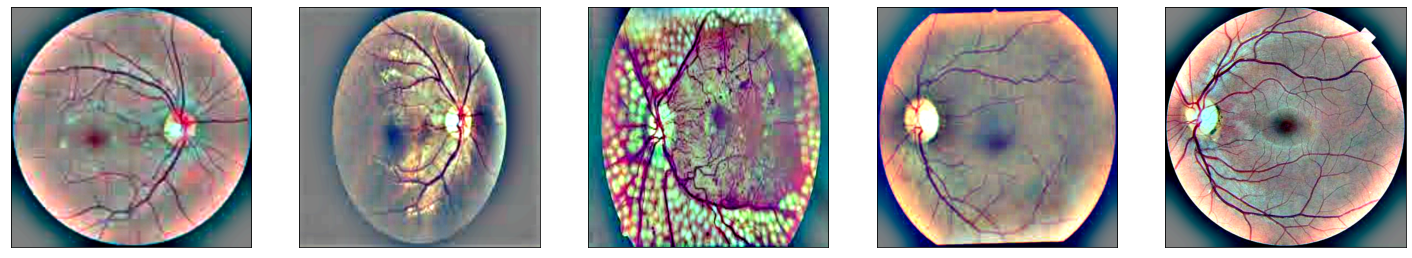

In [74]:
%%time

NUM_SAMP=7
fig = plt.figure(figsize=(25, 16))
        
for i in range(1,6,1):
        path=(f"/Users/lucieluneau/Downloads/bidon/{i}.jpeg")
        ax = fig.add_subplot(1,5,i,xticks=[], yticks=[])
        image = load_ben_color(path,sigmaX=30)
        plt.imshow(image)

## 3.A2 Try the new idea of circle crop

@taindow proposes an interesting idea of making a circle crop to the image, so I update the kernel to let you compare the results. Credit : https://www.kaggle.com/taindow/pre-processing-train-and-test-images ... Observe that we now get a magic circle, but by using circle crop, some scabs/wools may get loss.

In [72]:
def circle_crop(img, sigmaX=10):   
    """
    Create circular crop around image centre    
    """    
    
    img = cv2.imread(img)
    img = crop_image_from_gray(img)    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    height, width, depth = img.shape    
    
    x = int(width/2)
    y = int(height/2)
    r = np.amin((x,y))
    
    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x,y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)
    img = crop_image_from_gray(img)
    img=cv2.addWeighted ( img,4, cv2.GaussianBlur( img , (0,0) , sigmaX) ,-4 ,128)
    return img 

CPU times: user 1.4 s, sys: 12.8 ms, total: 1.41 s
Wall time: 515 ms


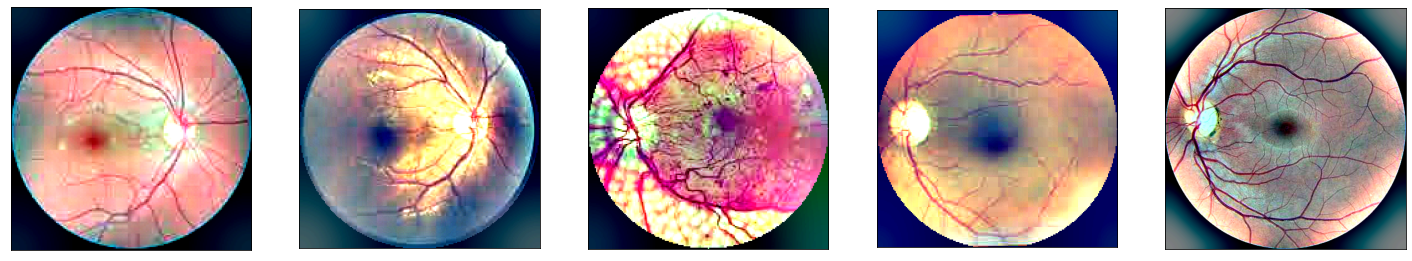

In [73]:
%%time
fig = plt.figure(figsize=(25, 16))
        
for i in range(1,6,1):
        path=(f"/Users/lucieluneau/Downloads/bidon/{i}.jpeg")
        ax = fig.add_subplot(1,5,i,xticks=[], yticks=[])
        image = circle_crop(path,sigmaX=30)
        plt.imshow(image)


        


We can try plotting a picture (sample train pic(4,1) above) with IMG_SIZE with cropping, now important information is much clearer to see with `sigmaX = 10`

512 512


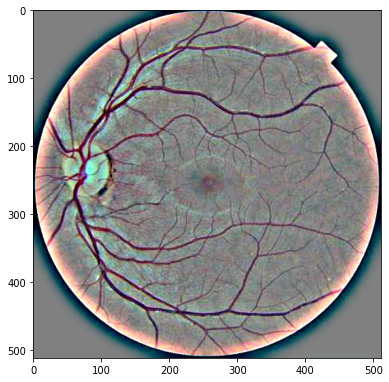

In [75]:
dpi = 80 #inch

# path=f"../input/aptos2019-blindness-detection/train_images/5c7ab966a3ee.png" # notice upper part
path=f"/Users/lucieluneau/Downloads/bidon/{i}.jpeg" # lower-right, can be class3
image = load_ben_color(path,sigmaX=10)

height, width = IMG_SIZE, IMG_SIZE
print(height, width)

SCALE=1
figsize = (width / float(dpi))/SCALE, (height / float(dpi))/SCALE

fig = plt.figure(figsize=figsize)
plt.imshow(image, cmap='gray')


## Try the method on Public Test Set
We can also try auto cropping on 50 test data to see that it work fine. Below, we see immediately from this random samples that severed cases, with level >2, are relatively many more compared to the training set.

CPU times: user 2.53 s, sys: 17 ms, total: 2.55 s
Wall time: 1.21 s


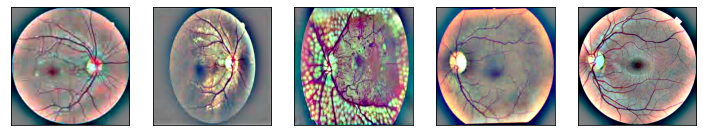

In [78]:
%%time
NUM_SAMP=10
fig = plt.figure(figsize=(25, 16))
for i in range(1,6,1):
        path=(f"/Users/lucieluneau/Downloads/bidon/{i}.jpeg")
        ax = fig.add_subplot(5, NUM_SAMP, jj * NUM_SAMP + i + 1, xticks=[], yticks=[])
#         path=f"/Users/lucieluneau/Downloads/131128_418031_bundle_archive/resized_train/resized_train/{row['id_code']}"
        image = load_ben_color(path,sigmaX=30)
        
        plt.imshow(image)
#         ax.set_title('%d-%s' % (idx, row['id_code']) )

CPU times: user 7.29 s, sys: 36.6 ms, total: 7.33 s
Wall time: 2.66 s


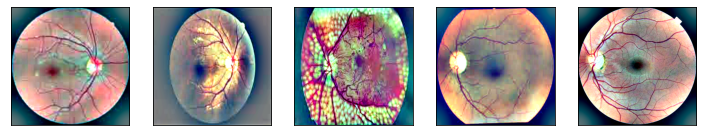

In [80]:
%%time
'''Bonus : sigmaX=50'''
NUM_SAMP=10
fig = plt.figure(figsize=(25, 16))
for i in range(1,6,1):
        path=(f"/Users/lucieluneau/Downloads/bidon/{i}.jpeg")
        ax = fig.add_subplot(5, NUM_SAMP, jj * NUM_SAMP + i + 1, xticks=[], yticks=[])
#         path=f"../input/aptos2019-blindness-detection/test_images/{row['id_code']}.png"
        image = load_ben_color(path,sigmaX=50)

        plt.imshow(image, cmap='gray')
#         ax.set_title('%d-%s' % (idx, row['id_code']) )

In [164]:
'''
# This is the old imperfect 'by-channel' color cropping code
# this code can cause different crop among 3 channels

# try cropping color image with the fixed function
# path=f"../input/aptos2019-blindness-detection/train_images/5c7ab966a3ee.png"
path=f"../input/aptos2019-blindness-detection/train_images/cd54d022e37d.png"
image = cv2.imread(path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = crop_image(image)
# image = crop_image_from_gray(image)
image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
image=cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0) , 10) ,-4 ,128)

height, width = IMG_SIZE, IMG_SIZE
print(height, width)

SCALE=1
figsize = (width / float(dpi))/SCALE, (height / float(dpi))/SCALE

fig = plt.figure(figsize=figsize)
plt.imshow(image)
'''

'\n# This is the old imperfect \'by-channel\' color cropping code\n# this code can cause different crop among 3 channels\n\n# try cropping color image with the fixed function\n# path=f"../input/aptos2019-blindness-detection/train_images/5c7ab966a3ee.png"\npath=f"../input/aptos2019-blindness-detection/train_images/cd54d022e37d.png"\nimage = cv2.imread(path)\nimage = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)\nimage = crop_image(image)\n# image = crop_image_from_gray(image)\nimage = cv2.resize(image, (IMG_SIZE, IMG_SIZE))\nimage=cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0) , 10) ,-4 ,128)\n\nheight, width = IMG_SIZE, IMG_SIZE\nprint(height, width)\n\nSCALE=1\nfigsize = (width / float(dpi))/SCALE, (height / float(dpi))/SCALE\n\nfig = plt.figure(figsize=figsize)\nplt.imshow(image)\n'

# 4. Try the same method to Past competition data
Thanks @tanlikesmath, https://www.kaggle.com/tanlikesmath/diabetic-retinopathy-resized who provides us a complete previous-competition dataset in the .jpeg format; this is much smaller than the original version with the risk of losing image details. Let apply both normal gray scale, and Ben Graham's method to this dataset.

In [ ]:
!ls ../input/diabetic-retinopathy-resized/

In [ ]:
!ls ../input/diabetic-retinopathy-resized/resized_train/resized_train | head

In [ ]:
df_old = pd.read_csv('../input/diabetic-retinopathy-resized/trainLabels.csv')

df_old.head()

In [ ]:
NUM_SAMP=10
fig = plt.figure(figsize=(25, 16))
for class_id in sorted(train_y.unique()):
    for i, (idx, row) in enumerate(df_old.loc[df_old['level'] == class_id].sample(NUM_SAMP, random_state=SEED).iterrows()):
        ax = fig.add_subplot(5, NUM_SAMP, class_id * NUM_SAMP + i + 1, xticks=[], yticks=[])
        path=f"../input/diabetic-retinopathy-resized/resized_train/resized_train/{row['image']}.jpeg"
        image = load_ben_color(path,sigmaX=30)

        plt.imshow(image)
        ax.set_title('%d-%d-%s' % (class_id, idx, row['image']) )

Below is the unpreprocess version, just for comparison

In [ ]:
NUM_SAMP=10
fig = plt.figure(figsize=(25, 16))
for class_id in sorted(train_y.unique()):
    for i, (idx, row) in enumerate(df_old.loc[df_old['level'] == class_id].sample(NUM_SAMP, random_state=SEED).iterrows()):
        ax = fig.add_subplot(5, NUM_SAMP, class_id * NUM_SAMP + i + 1, xticks=[], yticks=[])
        path=f"../input/diabetic-retinopathy-resized/resized_train/resized_train/{row['image']}.jpeg"
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

#         image = crop_image_from_gray(image)
        image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
#         image=cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0) , IMG_SIZE/10) ,-4 ,128)

        plt.imshow(image, cmap='gray')
        ax.set_title('%d-%d-%s' % (class_id, idx, row['image']) )

Ok preprocessing methods seem to works fine; however, the doctors to estimate the severity levels in the past competitions may have different criteria in mind than the doctors of Aravind, so it is possible to have some estimation inconsistency (at least to my eyes the previous data seems more noisy). The following level-4 [pic(4,1) in the plot we just made above] looks not so severe. (Or this is the example case of too many blood vessels ??, refer to Section 1.1)

In [ ]:
dpi = 80 #inch

path=f"../input/diabetic-retinopathy-resized/resized_train/resized_train/31590_right.jpeg" # too many vessels?
# path=f"../input/diabetic-retinopathy-resized/resized_train/resized_train/18017_left.jpeg" # details are lost
image = load_ben_color(path,sigmaX=30)
# image = cv2.imread(path)
# image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# image = crop_image1(image)
# image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
# image=cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0) , IMG_SIZE/10) ,-4 ,128)

height, width = IMG_SIZE, IMG_SIZE
print(height, width)

SCALE=1
figsize = (width / float(dpi))/SCALE, (height / float(dpi))/SCALE

fig = plt.figure(figsize=figsize)
plt.imshow(image, cmap='gray')

## 4.1 Let us compare to the .png image.

Some pictures (e.g. pics (4,5-8)) seem to lost details perhaps this is due to .jpeg compression ? I don't think so, but at least we should try to compare with .png. Fortunately, @donkeys also provides us .png version of the previous competition [see ref. in Introduction].

In [ ]:
!ls ../input/retinopathy-train-2015/rescaled_train_896/rescaled_train_896/ | head

In [ ]:
dpi = 80 #inch

path_jpg=f"../input/diabetic-retinopathy-resized/resized_train/resized_train/18017_left.jpeg" # too many vessels?
path_png=f"../input/retinopathy-train-2015/rescaled_train_896/rescaled_train_896/18017_left.png" # details are lost
image = cv2.imread(path_png)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = crop_image(image)
image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))

image2 =  cv2.imread(path_jpg)
image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)
image2 = crop_image(image2)
image2 = cv2.resize(image2, (IMG_SIZE, IMG_SIZE))


height, width = IMG_SIZE, IMG_SIZE
print(height, width)

SCALE=1/4
figsize = (width / float(dpi))/SCALE, (height / float(dpi))/SCALE

fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(2, 2, 1, xticks=[], yticks=[])
ax.set_title('png format original' )
plt.imshow(image, cmap='gray')
ax = fig.add_subplot(2, 2, 2, xticks=[], yticks=[])
ax.set_title('jpg format original' )
plt.imshow(image2, cmap='gray')

image = load_ben_color(path_png,sigmaX=30)
image2 = load_ben_color(path_jpg,sigmaX=30)
ax = fig.add_subplot(2, 2, 3, xticks=[], yticks=[])
ax.set_title('png format transformed' )
plt.imshow(image, cmap='gray')
ax = fig.add_subplot(2, 2, 4, xticks=[], yticks=[])
ax.set_title('jpg format transformed' )
plt.imshow(image2, cmap='gray')

OK, so the details are really not there no matter what image compression method. So this may be one example of (many) noisy data in the previous competition. 

# Appendix A. Heatmap visualization

In **[this new kernel](https://www.kaggle.com/ratthachat/aptos-spotting-blindness-real-or-spurious/)**, I show another application of preprocessing method, to visualize (and improve) understanbility of the model. If you are interested in please visit the kernel.

![heatmap](https://i.ibb.co/6FM6VCC/gradcam-resized.png)

# Appendix B. Inconsistency of Ophthalmologist's Estimation

Be careful that the nature of this problem is noisy. One Doctor can estimate an eye with severity level 3, but another can say level 1. In fact, some doctor can even say level 5! See evidence below from Tensorflow summit. For more information see https://youtu.be/oOeZ7IgEN4o?t=156 .

![inconsistent  estimation in diabetic retinophaty](https://i.ibb.co/6rQ2sFG/inconsistent-estimation.png)

Actually, from this summit, Google stated that they already worked with Aravind and have like 800,000 training data. I am a bit confused about the objective of this competition :) .

# Appendix C. Infinite Vision: The Story of Aravind Eye Hospital

I really would love everyone to watch ** [this clip](http://) ** to appreciate the story of Aravind and the this competition! Enjoy.

![Aravind Business Model??](https://i.ibb.co/m4C3xWd/Aravind-Model.png)



That's all for now! Hope this is helpful somehow! 